# Sales Forecasting

## Data Exploration

In [129]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

path = 'kaggle/input'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input\holidays_events.csv
kaggle/input\oil.csv
kaggle/input\sample_submission.csv
kaggle/input\stores.csv
kaggle/input\test.csv
kaggle/input\train.csv
kaggle/input\transactions.csv


In [130]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [131]:
stores = pd.read_csv(os.path.join(path, 'stores.csv'))
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [132]:
print(f'store_nbr: {np.sort(train_df['store_nbr'].unique())}\nlength: {len(train_df['store_nbr'].unique())}\n')

print(f'family: {np.sort(train_df['family'].unique())}\nlength: {len(train_df['family'].unique())}\n')

print(f'cluster: {np.sort(stores['cluster'].unique())}\n')

store_nbr: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
length: 54

family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
length: 33

cluster: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]



In [133]:
oil = pd.read_csv(os.path.join(path, 'oil.csv'))
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [134]:
holiday_events = pd.read_csv(os.path.join(path, 'holidays_events.csv'))
holiday_events['date'] = pd.to_datetime(holiday_events['date'])
holiday_events = holiday_events[holiday_events['transferred'] == False]
holiday_events['holiday'] = True
holiday_events.head()

,date,type,locale,locale_name,description,transferred,holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,True
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,True
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,True
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,True
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,True


In [135]:
store_nbr_cat = train_df['store_nbr'].astype('category').cat
store_nbr_categories = store_nbr_cat.categories

family_cat = train_df['family'].astype('category').cat
family_categories = family_cat.categories

print(f'store_nbr categories: {store_nbr_categories}')
print(f'family categories: {family_categories}')

store_nbr categories: Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
      dtype='int64')
family categories: Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object')


## Feature Engineering and Preprocessing

In [136]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier


class PreProcessor:
    def __init__(self, path='kaggle/input', lags=[1,2,7], avg_windows=[7,14,30], normalize_sales=True, normalize_promos=True):
        self.path = path
        self.input_size = None

        self.store_nbr_categories = pd.read_csv(os.path.join(path, 'stores.csv'))['store_nbr'].astype('category').cat.categories
        self.family_categories = pd.read_csv(os.path.join(path, 'train.csv'))['family'].astype('category').cat.categories
        self.type_categories = pd.read_csv(os.path.join(path, 'stores.csv'))['type'].astype('category').cat.categories
        self.cluster_categories = pd.read_csv(os.path.join(path, 'stores.csv'))['cluster'].astype('category').cat.categories

        self.lags = lags
        self.avg_windows = avg_windows

        self.normalize_sales = normalize_sales
        self.normalize_promos = normalize_promos
        self.sales_norm_vals = None
        self.promo_norm_vals = None

        oil = pd.read_csv(os.path.join(path, 'oil.csv'))
        self.oil_mean = oil['dcoilwtico'].mean()
        self.oil_std = oil['dcoilwtico'].std()

    
    def _get_location(self, df):
        stores = pd.read_csv(os.path.join(path, 'stores.csv'))
        df = df.merge(stores, on='store_nbr', how='left')
        df = df[['id', 'date', 'store_nbr', 'family', 'type', 'cluster', 'sales', 'onpromotion', 'state', 'city']]
        
        return df


    def _get_oil(self, df):
        oil = pd.read_csv(os.path.join(path, 'oil.csv'))
        oil['date'] = pd.to_datetime(oil['date'])
        
        df = df.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
        
        df['dcoilwtico'] = df['dcoilwtico'].ffill()
        df['dcoilwtico'] = df['dcoilwtico'].bfill()
        
        return df


    def _get_holiday(self, df):
        holiday_events = pd.read_csv(os.path.join(path, 'holidays_events.csv'))
        holiday_events['date'] = pd.to_datetime(holiday_events['date'])

        holiday_events = holiday_events[holiday_events['transferred'] == False]

        # working_days = holiday_events[holiday_events['type'].isin(['Work Day'])].copy()
        # working_days['work_day'] = True

        holidays = holiday_events[holiday_events['type'].isin(['Holiday', 'Transfer'])].copy()
        holidays['holiday'] = True

        special_days = holiday_events[holiday_events['type'].isin(['Additional', 'Event', 'Bridge'])].copy()
        special_days['special_day'] = True

        # Merge holidays
        df = df.merge(holidays[holidays['locale'] == 'National'][['date', 'holiday']], on='date', how='left')
        df = df.merge(holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'holiday']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
        df = df.merge(holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'holiday']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
        
        df['holiday'] = df['holiday'] | df['holiday_y'] | df['holiday_x']
        df = df.drop(columns=['holiday_x', 'holiday_y', 'locale_name_x', 'locale_name_y'])
        df['holiday'] = df['holiday'].fillna(0).astype(int)

        df['before_holiday'] = df.groupby(['store_nbr', 'family'], observed=True)['holiday'].shift(-1).fillna(0).astype(int)
        df['after_holiday'] = df.groupby(['store_nbr', 'family'], observed=True)['holiday'].shift(1).fillna(0).astype(int)

        # Merge special days
        df = df.merge(special_days[special_days['locale'] == 'National'][['date', 'special_day']], on='date', how='left')
        df = df.merge(special_days[special_days['locale'] == 'Regional'][['date', 'locale_name', 'special_day']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
        df = df.merge(special_days[special_days['locale'] == 'Local'][['date', 'locale_name', 'special_day']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
        
        df['special_day'] = df['special_day'] | df['special_day_y'] | df['special_day_x']
        df = df.drop(columns=['special_day_x', 'special_day_y', 'locale_name_x', 'locale_name_y'])
        df['special_day'] = df['special_day'].fillna(0).astype(int)

        # Merge working days
        # df = df.merge(working_days[['date', 'work_day']], on='date', how='left')
        # df['work_day'] = df['work_day'].fillna(0).astype(int)

        df['store_closed'] = ((df['date'].dt.month == 1) & (df['date'].dt.day == 1)).astype(int)
        
        return df


    def _get_seasonality(self, df, order=1, min_date=pd.to_datetime('2013-01-01'), max_date=pd.to_datetime('2017-08-31')):
        uniq_idx = pd.date_range(min_date, max_date, freq='D')

        fourier = CalendarFourier(freq='YE', order=order)

        dp = DeterministicProcess(
            index = uniq_idx,
            order = 0,
            constant = False,
            seasonal = True,
            additional_terms = [fourier],
            drop = False
        )

        det_feats = dp.in_sample()

        df = df.merge(det_feats, left_on='date', right_index=True, how='left')

        return df


    def _get_lags(self, df, fill_na=False):
        lag_names = [f'sales_lag_{lag}' for lag in self.lags]

        for lag in self.lags:
            df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'], observed=True)['sales'].shift(lag)
            
            if fill_na:
                df[f'sales_lag_{lag}'] = df[f'sales_lag_{lag}'].fillna(0)

        df['pct_change_cur'] = (
            df
            .groupby(['store_nbr', 'family'])['sales']
            .transform(lambda s: s.pct_change(periods=1, fill_method=None))
        )
        df['pct_change_cur'] = df['pct_change_cur'].fillna(1)

        df['pct_change'] = df.groupby(['store_nbr', 'family'])['pct_change_cur'].shift(1)
        df['pct_change'] = df['pct_change'].fillna(1)
        df['pct_change'] = np.clip(df['pct_change'], -1.0, 10.0)

        df = df.drop(columns=['pct_change_cur'])

        if -1 in self.lags:
            lag_names.remove('sales_lag_-1')
        
        return df, lag_names


    def _get_windows(self, df, fill_na=False):
        window_names = [f'sales_window_{window}' for window in self.avg_windows]

        for window in self.avg_windows:
            df[f'sales_window_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            df[f'sales_window_{window}'] = df.groupby(['store_nbr', 'family'])[f'sales_window_{window}'].shift(1)
            
            if fill_na:
                df[f'sales_window_{window}'] = df[f'sales_window_{window}'].fillna(0)

        return df, window_names


    def _set_active_status(self, df):
        df['active'] = 1
        df.loc[(df['sales'] == 0) & ((df['sales_lag_1'] == 0) | (df['sales_lag_-1'] == 0)), 'active'] = 0
        df.loc[df['active'] == 0, 'sales'] = np.nan
        df = df.drop(columns=(['sales_lag_-1', 'active']))

        return df
    

    def renormalize(self, df):
        if self.sales_norm_vals is not None:
            df = df.merge(self.sales_norm_vals, on=['store_nbr', 'family'], how='left')
            df['mean'] = df['mean'].fillna(0)
            df['std'] = df['std'].fillna(1)

            df['sales'] = df['sales'].astype('float64')
            df['sales'] = (df['sales'] * df['std']) + df['mean']
            df['sales'] = df['sales'].astype('float32')

            df = df.drop(columns=['mean', 'std'])

        return df


    def process(self, df, proc_date=None, test=False, fill_na=False, remove_na=True):
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])

        if not test:
            df['sales'] = df.groupby(['store_nbr', 'family'], observed=True)['sales'].transform(
                lambda s: s.mask((s == 0) & (s.cummax() == 0))
            )
        df = self._get_location(df)
        df = self._get_oil(df)
        df = self._get_holiday(df)
        df, lag_names = self._get_lags(df, fill_na=fill_na)
        df, window_names = self._get_windows(df, fill_na=fill_na)
        df = self._get_seasonality(df, order=12)

        df['store_nbr'] = df['store_nbr'].apply(lambda x: store_nbr_categories.get_loc(x))
        df['family'] = df['family'].apply(lambda x: family_categories.get_loc(x))
        df['type'] = df['type'].apply(lambda x: self.type_categories.get_loc(x))
        df['cluster'] = df['cluster'].apply(lambda x: self.cluster_categories.get_loc(x))

        if proc_date is not None:
            df = df[df['date'] == proc_date]

        if remove_na:
            df = df[~(df[lag_names + window_names].isna().any(axis=1))]

        for col in lag_names + window_names + ['sales']:
            df[col] = np.log1p(df[col])

        df['dcoilwtico'] = (df['dcoilwtico'] - self.oil_mean) / self.oil_std

        if not test:
            df = df.dropna(subset=['sales'])
            df = df.reset_index(drop=True)

        dates = df['date']
        df = df.drop(columns=['date', 'state', 'city', 'id'])

        if self.normalize_promos:
            df['onpromotion'] = df['onpromotion'].astype(float)
            if self.promo_norm_vals is None:
                self.promo_norm_vals = df.groupby(['store_nbr', 'family'], observed=True).agg({'onpromotion': ['mean', 'std']})
                self.promo_norm_vals = self.promo_norm_vals.reset_index()
                self.promo_norm_vals.columns = ['store_nbr', 'family', 'mean', 'std']

            df = df.merge(self.promo_norm_vals, on=['store_nbr', 'family'], how='left')
            df['mean'] = df['mean'].fillna(0)
            df['std'] = df['std'].fillna(1)
            df.loc[df['std'] == 0, 'std'] = 1

            df['onpromotion'] = (df['onpromotion'] - df['mean']) / df['std']
            df = df.drop(columns=['mean', 'std'])

        if self.normalize_sales:
            if self.sales_norm_vals is None:
                self.sales_norm_vals = df.groupby(['store_nbr', 'family'], observed=True).agg({'sales': ['mean', 'std']})
                self.sales_norm_vals = self.sales_norm_vals.reset_index()
                self.sales_norm_vals.columns = ['store_nbr', 'family', 'mean', 'std']

            df = df.merge(self.sales_norm_vals, on=['store_nbr', 'family'], how='left')
            df['mean'] = df['mean'].fillna(0)
            df['std'] = df['std'].fillna(1)
            df.loc[df['std'] == 0, 'std'] = 1

            for column in [col for col in df.columns if 'sales' in col]:
                df[column] = (df[column] - df['mean']) / df['std']
            df = df.drop(columns=['mean', 'std'])
        
        self.input_size = len(df.columns) - 5 # Exclude 'store_nbr', 'family', 'type', 'cluster', 'sales'

        return df, dates

In [137]:
def get_readable_preprocessed(df, proc_date=None, test=False, store_filter=None, family_filter=None, normalize_sales=False, normalize_promos=False):
    if store_filter is not None:
        df = df[df['store_nbr'] == store_filter]
    if family_filter is not None:
        df = df[df['family'] == family_filter]

    preprocessor = PreProcessor(normalize_sales=normalize_sales, normalize_promos=normalize_promos)

    df, dates = preprocessor.process(df, proc_date=proc_date, test=test)

    sales_cols = [col for col in df.columns if 'sales' in col]
    
    if not normalize_sales:
        df[sales_cols] = np.expm1(df[sales_cols])
    
    df['date'] = dates
    df['store_nbr'] = preprocessor.store_nbr_categories[df['store_nbr']]
    df['family'] = preprocessor.family_categories[df['family']]
    df['type'] = preprocessor.type_categories[df['type']]
    df['cluster'] = preprocessor.cluster_categories[df['cluster']]

    df['dcoilwtico'] = df['dcoilwtico'] * 25.6708 + 67.8197

    df = df[['date', 'store_nbr', 'family', 'onpromotion'] + sales_cols + ['pct_change', 'dcoilwtico', 'before_holiday', 'holiday', 'after_holiday', 'special_day', 'store_closed']]
    
    return df

In [138]:
# ex_sample = pd.read_csv(os.path.join(path, 'train.csv'))
# ex_sample = get_readable_preprocessed(ex_sample, family_filter='SCHOOL AND OFFICE SUPPLIES', normalize_sales=False, normalize_promos=False)
# # # ex_sample = ex_sample[(ex_sample['store_nbr'] == 1) & (ex_sample['family'] == 'HARDWARE')]
# # ex_sample = ex_sample[(ex_sample['family'] == 'SCHOOL AND OFFICE SUPPLIES')]
# # prep = PreProcessor(normalize_sales=False, normalize_promos=False)
# # ex_sample, _ = prep.process(ex_sample)
# ex_sample.to_csv('sample_preprocessed.csv', index=False)

# print(f'Norm values:\n{norm_vals}')

# ex_sample2 = pd.read_csv(os.path.join(path, 'train.csv'))
# ex_sample2 = ex_sample2[(ex_sample2['store_nbr'] == 1) & (ex_sample2['family'] == 'HOME CARE')]
# ex_sample2.to_csv('sample_2.csv', index=False)

## Data Visualization

In [139]:
x = train_df.copy()
x['date'] = pd.to_datetime(x['date'])
x = x.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

oil = pd.read_csv(os.path.join(path, 'oil.csv'))
oil['date'] = pd.to_datetime(oil['date'])
x = x.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
x['dcoilwtico'] = x['dcoilwtico'].ffill()
x['dcoilwtico'] = x['dcoilwtico'].bfill()

In [140]:
combos = x[['store_nbr', 'family']].drop_duplicates().reset_index(drop=True)

combo_sample = x.merge(combos.sample(10, random_state=42), on=['store_nbr', 'family'], how='inner')

combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16840 entries, 0 to 16839
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           16840 non-null  int64         
 1   date         16840 non-null  datetime64[ns]
 2   store_nbr    16840 non-null  int64         
 3   family       16840 non-null  object        
 4   sales        16840 non-null  float64       
 5   onpromotion  16840 non-null  int64         
 6   city         16840 non-null  object        
 7   state        16840 non-null  object        
 8   dcoilwtico   16840 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.2+ MB


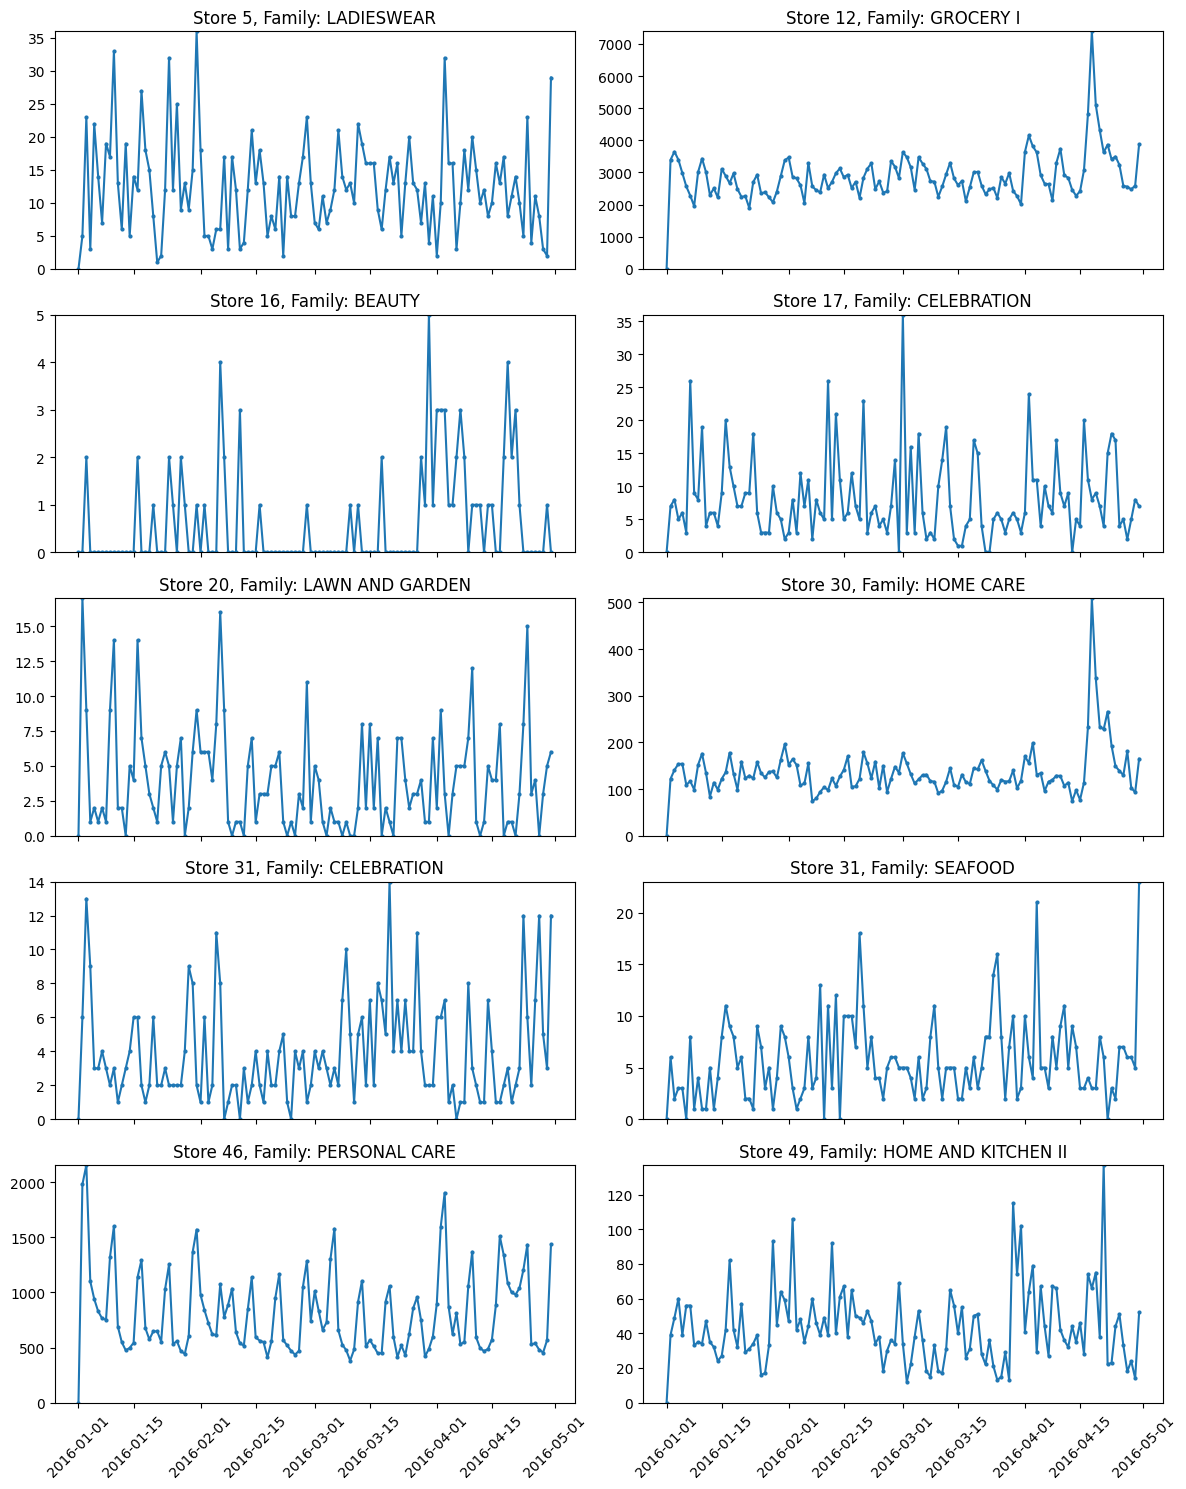

In [141]:
combo_sample['date'] = pd.to_datetime(combo_sample['date'])
combo_sample = combo_sample[combo_sample['date'].dt.year == 2016]
combo_sample = combo_sample[combo_sample['date'].dt.month < 5]
groups = combo_sample.groupby(['store_nbr', 'family'])

fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)
axs = axs.flatten()

for ax, ((store_nbr, family), group) in zip(axs, groups):
    group = group.sort_values('date')
    ax.plot(group['date'], group['sales'], marker='o', markersize=2)
    ax.set_title(f'Store {store_nbr}, Family: {family}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(group['sales'].min(), group['sales'].max())

plt.tight_layout()
plt.show()

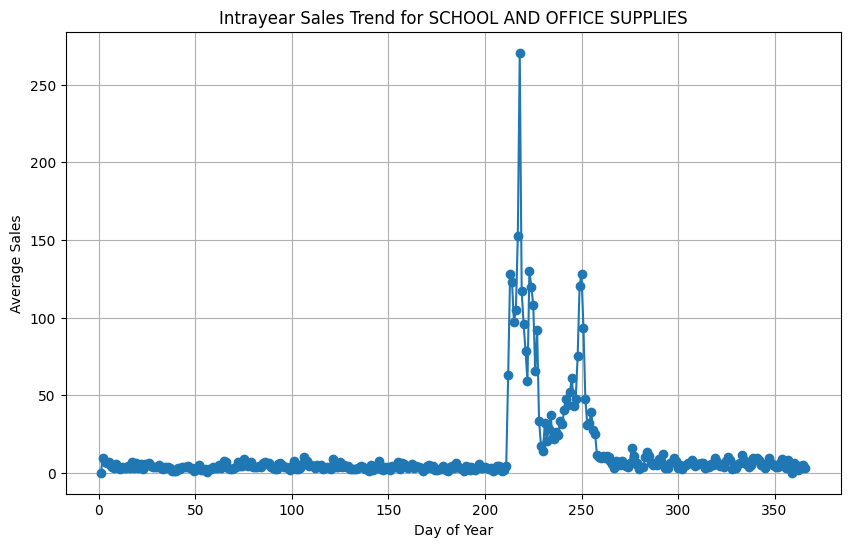

In [142]:
subset = train_df[train_df['family'] == 'SCHOOL AND OFFICE SUPPLIES'].copy()
subset = subset[subset['store_nbr'] == 47]  # Filter for a specific store, e.g., store number 1
subset['date'] = pd.to_datetime(subset['date'])
subset['dayofyear'] = subset['date'].dt.dayofyear

sales_trend = subset.groupby('dayofyear')['sales'].mean()

plt.figure(figsize=(10, 6))
plt.plot(sales_trend.index, sales_trend.values, marker='o')
plt.title("Intrayear Sales Trend for SCHOOL AND OFFICE SUPPLIES")
plt.xlabel("Day of Year")
plt.ylabel("Average Sales")
plt.grid(True)
plt.show()

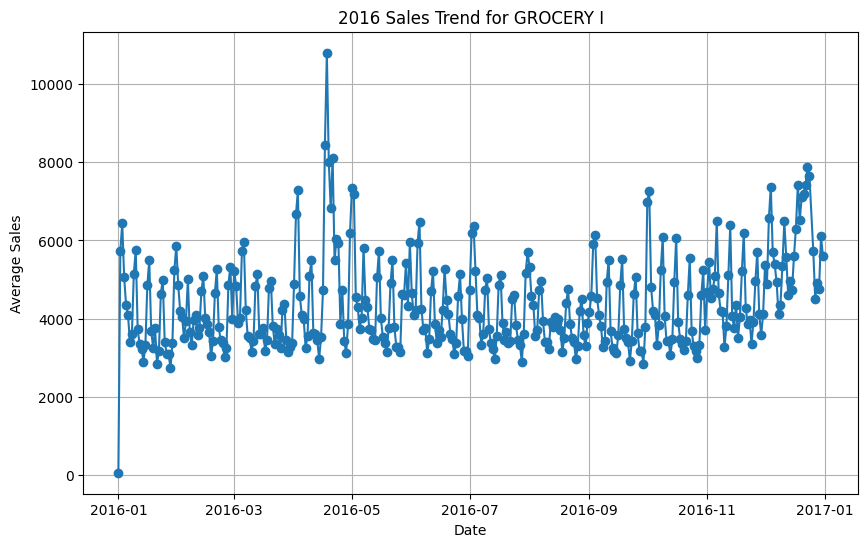

In [143]:
family = 'GROCERY I'
subset = train_df[train_df['family'] == family].copy()
subset['date'] = pd.to_datetime(subset['date'])
subset = subset[subset['date'].dt.year == 2016]
# subset = subset[subset['store_nbr'] == 47]  # Filter for a specific store, e.g., store number 1
# subset['dayofyear'] = subset['date'].dt.dayofyear

sales_trend = subset.groupby('date')['sales'].mean()

plt.figure(figsize=(10, 6))
plt.plot(sales_trend.index, sales_trend.values, marker='o')
plt.title(f"2016 Sales Trend for {family}")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.grid(True)
plt.show()

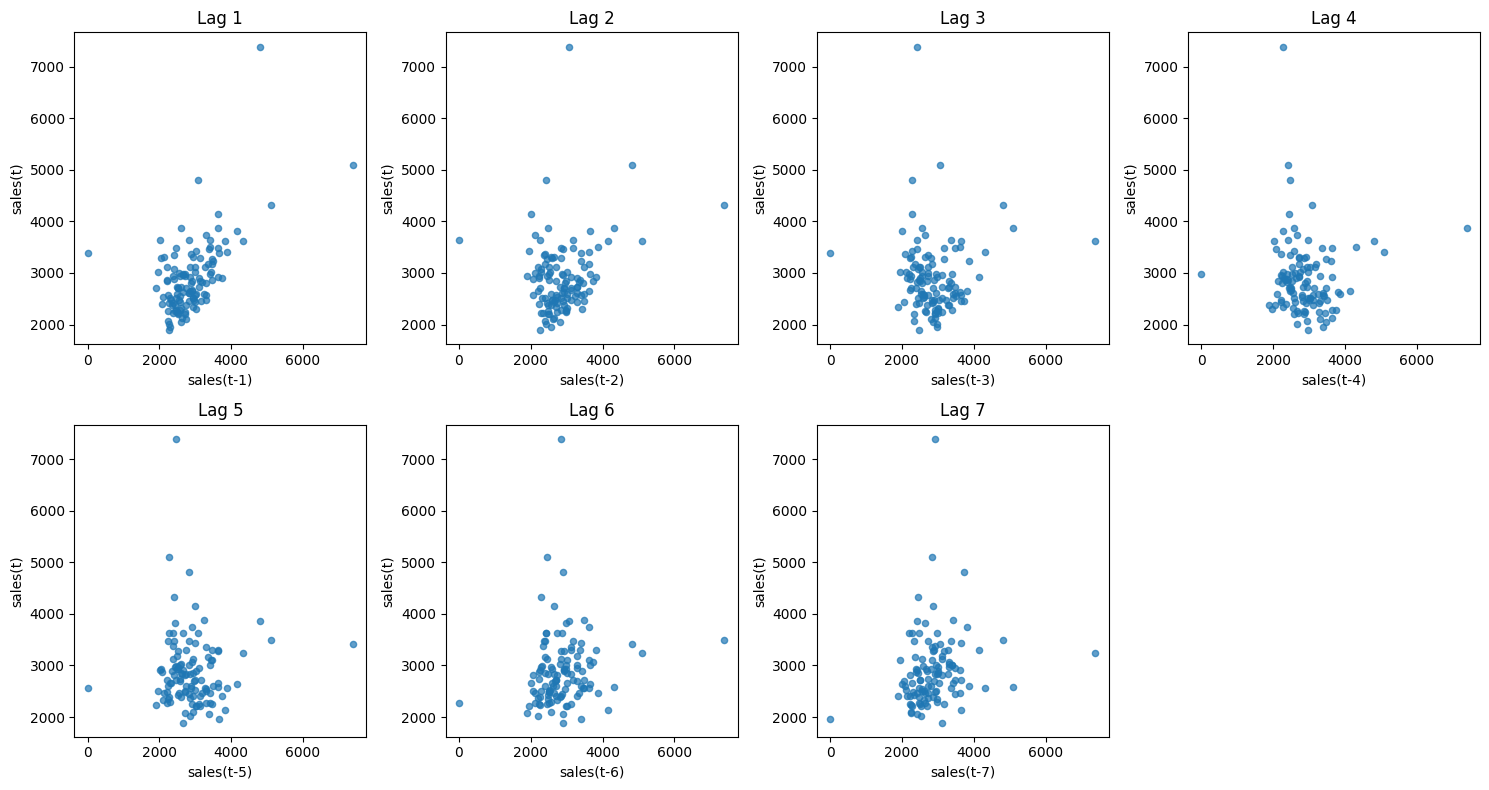

In [144]:
# Get the first group from the groups object and sort by date
first_key, first_group = list(groups)[1]
first_group = first_group.sort_values('date')
sales = first_group['sales'].reset_index(drop=True)

# Create lag plots for lags 1 through 7
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for lag in range(1, 8): 
    shifted = sales.shift(lag)
    # Ensure we only compare valid (non-NaN) points
    valid = shifted.notna()
    axes[lag - 1].scatter(shifted[valid], sales[valid], s=20, alpha=0.7)
    axes[lag - 1].set_title(f'Lag {lag}')
    axes[lag - 1].set_xlabel(f'sales(t-{lag})')
    axes[lag - 1].set_ylabel('sales(t)')

# Disable the unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

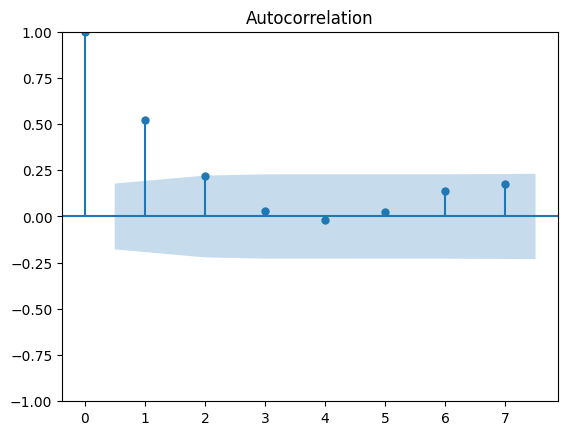

In [145]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales, lags=7)
plt.show()

In [146]:
# Source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

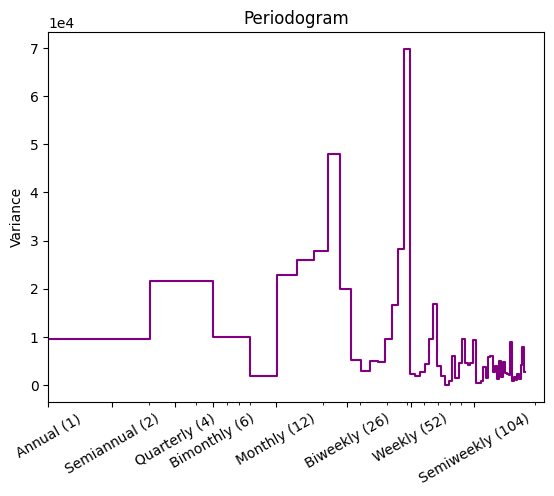

In [147]:
plot_periodogram(sales)

## Memory Cleanup

In [148]:
import gc, sys

def free_memory():
    freed = 0            # keep a running total of bytes released

    for name, obj in list(globals().items()):
        if isinstance(obj, (pd.DataFrame, np.ndarray)):
            size = sys.getsizeof(obj)
            del globals()[name]        # remove the variable
            freed += size

    gc.collect()          # force-free any orphaned buffers

    print(f"🗑️  Freed {freed/1_048_576:,.2f} MB")

## MLP

### Model and Dataset Architecture

In [149]:
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_col='sales'):
        self.dataframe = dataframe
        self.target_col = target_col
        self.features = dataframe.drop(columns=[target_col])
        self.targets = dataframe[target_col].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        vals = self.features.iloc[idx].values
        store_nbr = torch.tensor(vals[0], dtype=torch.long)
        family = torch.tensor(vals[1], dtype=torch.long)
        type = torch.tensor(vals[2], dtype=torch.long)
        cluster = torch.tensor(vals[3], dtype=torch.long)
        X = torch.tensor(vals[4:], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return store_nbr, family, type, cluster, X, y
    
def load_data(df, preprocessor: PreProcessor, ttsplit: bool=False, test_size: float=0.2, **kwargs):
    df, _ = preprocessor.process(df)
    if ttsplit:
        train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
        train_dataset = CustomDataset(train_df)
        val_dataset = CustomDataset(val_df)
        return DataLoader(train_dataset, **kwargs), DataLoader(val_dataset, **kwargs)
    dataset = CustomDataset(df)
    return DataLoader(dataset, **kwargs)
    
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        log_y_pred = torch.log1p(y_pred)
        log_y_true = torch.log1p(y_true)
        loss = torch.mean((log_y_pred - log_y_true) ** 2)
        return torch.sqrt(loss)

In [150]:
class SalesModel(nn.Module):
    def __init__(self, input_size, 
                 store_embed=16, fam_embed=16, type_embed=2, cluster_embed=5,
                 hidden=(512,256,128), p_drop=0.2):
        super().__init__()
        self.store_emb = nn.Embedding(54,  store_embed)
        self.fam_emb = nn.Embedding(33, fam_embed)
        self.type_emb = nn.Embedding(5, type_embed)
        self.cluster_emb = nn.Embedding(17, cluster_embed)

        layers = []
        prev = store_embed + fam_embed + type_embed + cluster_embed + input_size
        for h in hidden:
            layers += [
                nn.Linear(prev, h),
                nn.GELU(),
                nn.Dropout(p_drop)
            ]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, store_idx, fam_idx, type_idx, clust_idx, X):
        x = torch.cat([
            self.store_emb(store_idx),
            self.fam_emb(fam_idx),
            self.type_emb(type_idx),
            self.cluster_emb(clust_idx),
            X
        ], dim=1)
        return self.mlp(x).squeeze(-1)

### Training and Inference Functions

In [151]:
import pickle
from datetime import datetime
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MSELoss

In [152]:
def evaluate(
    model: SalesModel = None,
    preprocessor: PreProcessor = None,
    model_path: str = '',
    model_name: str = "sales_model.th",
    batch_size: int = 128,
    silence: bool = False,
    **kwargs,
):

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    if model is None:
        model_path = Path(model_path)

        with open(model_path / 'preprocessor.pkl', 'rb') as f:
            preprocessor = pickle.load(f)

        model = SalesModel(input_size=preprocessor.input_size)
        model.load_state_dict(torch.load(model_path / model_name, map_location=device))
        model = model.to(device)
        
    model.eval()

    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
    train_df['date'] = pd.to_datetime(train_df['date'])

    max_date = train_df['date'].max()
    start_date = max_date - pd.Timedelta(days=15)

    test_df = train_df[train_df['date'] >= start_date].copy()

    train_df.loc[train_df['date'] >= start_date, 'sales'] = np.nan

    end_date = train_df['date'].max()
    context_date = start_date - pd.Timedelta(days=35)
    train_df = train_df[train_df['date'] >= context_date]

    if not silence:
        print(f'Context date: {context_date.strftime("%Y-%m-%d")}')
        print(f'Processing Range: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

    for proc_date in pd.date_range(start_date, end_date):
        df, _ = preprocessor.process(train_df, proc_date, test=True, fill_na=True, remove_na=False)
        
        test_data = DataLoader(CustomDataset(df, target_col='sales'), batch_size=batch_size, shuffle=False, num_workers=0)

        predictions = []

        with torch.inference_mode():
            for store_nbr, family, type, cluster, X, _ in test_data:
                store_nbr, family, type, cluster, X = store_nbr.to(device), family.to(device), type.to(device), cluster.to(device), X.to(device)
                pred = model(store_nbr, family, type, cluster, X)
                pred_with_label = torch.cat([store_nbr.unsqueeze(1), family.unsqueeze(1), pred.unsqueeze(1)], dim=1)
                predictions.append(pred_with_label.cpu().numpy())

        predictions = np.concatenate(predictions)
        predictions = pd.DataFrame(predictions, columns=['store_nbr', 'family', 'sales'])
        if preprocessor.normalize_sales:
            predictions = preprocessor.renormalize(predictions)
        predictions = np.expm1(predictions['sales'].values)
        train_df.loc[train_df['date'] == proc_date, 'sales'] = predictions
    
    train_df['sales'] = np.clip(train_df['sales'], 0, None)

    df = get_readable_preprocessed(train_df, proc_date=None, test=True)
    df = df.rename(columns={'sales': 'sales_pred'})
    df = df.merge(test_df[['store_nbr', 'family', 'date', 'sales']], on=['store_nbr', 'family', 'date'], how='left')
    df['SLE'] = (np.log1p(df['sales_pred']) - np.log1p(df['sales'])) ** 2
    df = df[df.columns[:5].tolist() + ['sales', 'SLE'] + df.columns[5:-2].tolist()]

    score = np.sqrt(df["SLE"].mean())
    if not silence:
        print(f'RMSLE: {score:.6f}')
    
    df.to_csv('validation_eval.csv', index=False)

    return score

In [153]:
def train(
    exp_dir: str = "logs",
    num_epoch: int = 50,
    warmup: int = 0,
    patience: int = 5,
    early_stop_thresh: int = 1e-3,
    early_stop_epoch: int = int(1e6),
    lr: float = 1e-3,
    cosine_anneal: bool = True,
    eta_min: float = 1e-5,
    batch_size: int = 128,
    seed: int = 42,
    val: bool = True,
    normalize_sales: bool = True,
    normalize_promos: bool = True,
    **kwargs,
):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    model_name = 'sales_model'

    # set random seed so each run is deterministic
    torch.manual_seed(seed)
    np.random.seed(seed)

    # directory with timestamp to save tensorboard logs and model checkpoints
    log_dir = Path(exp_dir) / f"{model_name}_z{datetime.now().strftime('%m%d_%H%M%S')}"
    logger = SummaryWriter(log_dir)

    df = pd.read_csv(os.path.join(path, 'train.csv'))

    preprocessor = PreProcessor(normalize_sales=normalize_sales, normalize_promos=normalize_promos)
    
    if val:
        df = df[df['date'] < '2017-07-31']
        train_data, val_data = load_data(df, preprocessor, ttsplit=True, shuffle=True, batch_size=batch_size, num_workers=0)
    else:
        train_data = load_data(df, preprocessor, shuffle=True, batch_size=batch_size, num_workers=0)

    with open(log_dir / 'preprocessor.pkl', "wb") as f:
        pickle.dump(preprocessor, f)

    model = SalesModel(input_size=preprocessor.input_size)
    model = model.to(device)
    model.train()

    # create loss function and optimizer
    loss_func = MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    if cosine_anneal:
        warmup_sched = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=0.1,
            total_iters=warmup
        )

        cosine_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=num_epoch - warmup,
            eta_min=1e-5
        )

        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[warmup_sched, cosine_sched],
            milestones=[warmup]
        )

    global_step = 0
    best_val = float('inf')

    print('Training started...\n')

    # training loop
    for epoch in range(num_epoch):
        metrics = {'train_loss': [], 'val_loss': []}

        for store_nbr, family, type, cluster, X, y in train_data:
            store_nbr, family, type, cluster, X = store_nbr.to(device), family.to(device), type.to(device), cluster.to(device), X.to(device)
            y = y.to(device)

            pred = model(store_nbr, family, type, cluster, X)
            loss = loss_func(pred, y)
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if global_step % 100 == 0:
                train_loss = torch.as_tensor(metrics["train_loss"]).mean()
                logger.add_scalar("train_loss", train_loss, global_step)
                metrics["train_loss"] = []

            global_step += 1

        if val:
            with torch.inference_mode():
                for store_nbr, family, type, cluster, X, y in val_data:
                    store_nbr, family, type, cluster, X = store_nbr.to(device), family.to(device), type.to(device), cluster.to(device), X.to(device)
                    y = y.to(device)

                    pred = model(store_nbr, family, type, cluster, X)
                    loss = loss_func(pred, y)
                    metrics['val_loss'].append(loss.item())
            
            epoch_val_loss = torch.as_tensor(metrics["val_loss"]).mean()
            logger.add_scalar("val_loss", epoch_val_loss, global_step)
            logger.add_scalar("val_loss_epoch", epoch_val_loss, epoch + 1)

        epoch_train_loss = torch.as_tensor(metrics["train_loss"]).mean()
        logger.add_scalar("train_loss", epoch_train_loss, global_step)
        
        epoch_val_loss = torch.as_tensor(metrics["val_loss"]).mean() if val else 0.0

        rmsle_score = evaluate(model, preprocessor, silence=True)
        logger.add_scalar("RMSLE", rmsle_score, global_step)
        logger.add_scalar("RMSLE_epoch", rmsle_score, epoch + 1)
        
        print(
            f"Epoch {epoch + 1:2d} / {num_epoch:2d}: "
            f"train_loss={epoch_train_loss:.4f} "
            f"val_loss={epoch_val_loss:.4f} "
            f"RMSLE={rmsle_score:.4f}\n"
        )

        torch.save(model.state_dict(), log_dir / f'{model_name}.th')

        if rmsle_score < best_val - early_stop_thresh:
            best_val = rmsle_score
            counter = 0
            best_wts = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stop at epoch {epoch + 1}")
                model.load_state_dict(best_wts)
                break

        if cosine_anneal:
            scheduler.step()

        if epoch + 1 >= early_stop_epoch:
            print(f"Forced early stop at epoch {epoch + 1}")
            break

    # save and overwrite the model in the root directory
    torch.save(model.state_dict(), f'{model_name}.th')
    with open('preprocessor.pkl', "wb") as f:
        pickle.dump(preprocessor, f)

    # save a copy of model weights in the log directory
    torch.save(model.state_dict(), log_dir / f'{model_name}.th')
    
    print(f"Model saved to {log_dir / f'{model_name}.th'}\n")

    if val:
        score = evaluate(model, preprocessor)
        print(f"Final RMSLE score: {score:.6f}")

    return

In [154]:
def create_submission(
    file_suffix: str,
    model_path: str = '',
    model_name: str = 'sales_model.th',
    batch_size: int = 128,
    **kwargs,
):

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    model_path = Path(model_path)

    with open(model_path / 'preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)

    model = SalesModel(input_size=preprocessor.input_size)
    model.load_state_dict(torch.load(model_path / model_name, map_location=device))
    model = model.to(device)
    model.eval()

    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(path, 'test.csv'))
    test_df['sales'] = np.nan

    merged_df = pd.concat([train_df, test_df], ignore_index=True)
    merged_df['date'] = pd.to_datetime(merged_df['date'])

    start_date = merged_df[merged_df['sales'].isna()]['date'].min()
    end_date = merged_df['date'].max()
    context_date = start_date - pd.Timedelta(days=35)
    merged_df = merged_df[merged_df['date'] >= context_date]

    print(f'Context date: {context_date.strftime("%Y-%m-%d")}')
    print(f'Processing Range: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

    for proc_date in pd.date_range(start_date, end_date):
        df, _ = preprocessor.process(merged_df, proc_date, test=True, fill_na=True, remove_na=False)
        
        test_data = DataLoader(CustomDataset(df, target_col='sales'), batch_size=batch_size, shuffle=False, num_workers=0)

        predictions = []

        with torch.inference_mode():
            for store_nbr, family, type, cluster, X, _ in test_data:
                store_nbr, family, type, cluster, X = store_nbr.to(device), family.to(device), type.to(device), cluster.to(device), X.to(device)
                pred = model(store_nbr, family, type, cluster, X)
                pred_with_label = torch.cat([store_nbr.unsqueeze(1), family.unsqueeze(1), pred.unsqueeze(1)], dim=1)
                predictions.append(pred_with_label.cpu().numpy())

        predictions = np.concatenate(predictions)
        predictions = pd.DataFrame(predictions, columns=['store_nbr', 'family', 'sales'])
        if preprocessor.normalize_sales:
            predictions = preprocessor.renormalize(predictions)
        predictions = np.expm1(predictions['sales'].values)
        
        merged_df.loc[merged_df['date'] == proc_date, 'sales'] = predictions

    merged_df['sales'] = np.clip(merged_df['sales'], 0, None)

    merged_df.to_csv(f'submissions/evaluation_{file_suffix}.csv', index=False)

    submission = merged_df[merged_df['date'] > pd.to_datetime('2017-08-15')][['id', 'sales']]
    submission.to_csv(f'submissions/submission_{file_suffix}.csv', index=False)

    print(f'Submission saved to submissions/submission_{file_suffix}.csv')

    return

### Execution

In [128]:
free_memory()

train(
    exp_dir='logs',
    num_epoch=50,
    warmup=5,
    patience=10,
    early_stop_thresh=1e-3,
    lr=3e-3,
    cosine_anneal=True,
    eta_min=6e-5,
    batch_size=1024,
    seed=42,
    val=True,
    normalize_sales=False,
    normalize_promos=False,
)

🗑️  Freed 0.00 MB
Training started...



KeyboardInterrupt: 

In [156]:
score = evaluate('logs/sales_model_z0610_120159')

Context date: 2017-06-26
Processing Range: 2017-07-31 to 2017-08-15
RMSLE: 0.404211


In [173]:
create_submission('v10')

Context date: 2017-07-12
Processing Range: 2017-08-16 to 2017-08-31
Submission saved to submissions/submission_v10.csv


## TFT

### Additional Preprocessing

In [23]:
def tft_preprocess(df, cutoff_date=None, **kwargs):
    df = df.copy()
    df, dates = preprocess(df, **kwargs)
    if cutoff_date is not None:
        df['date'] = pd.to_datetime(dates)
        df = df[df['date'] > cutoff_date]
        df = df.drop(columns=['date'])

    df['time_idx'] = df.groupby(['store_nbr', 'family'], observed=True).cumcount() + 1
    df['time_idx'] = df['time_idx'].astype(int)

    df['store_nbr'] = store_nbr_categories[df['store_nbr']].astype(str)
    df['family'] = family_categories[df['family']]

    return df, dates

### Model and Dataset Architecture

In [27]:
from pytorch_forecasting import (
    TimeSeriesDataSet, TemporalFusionTransformer
)
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting.data import GroupNormalizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

In [ ]:
class TFT(TemporalFusionTransformer):
    def configure_optimizers(self):
        # Define optimizer
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)

        warmup_epochs = 5
        total_epochs = self.trainer.max_epochs
        cosine_epochs = total_epochs - warmup_epochs

        # 1. Warmup: gradually increase LR from 0 to base LR
        warmup_scheduler = LinearLR(
            optimizer,
            start_factor=1e-8,  # effectively 0
            end_factor=1.0,
            total_iters=warmup_epochs
        )

        # 2. Cosine annealing after warmup
        cosine_scheduler = CosineAnnealingLR(
            optimizer,
            T_max=cosine_epochs,
            eta_min=1e-6
        )

        # Combine schedulers
        scheduler = SequentialLR(
            optimizer,
            schedulers=[warmup_scheduler, cosine_scheduler],
            milestones=[warmup_epochs]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

In [29]:
df = pd.read_csv(os.path.join(path, 'train.csv'))
df, _ = tft_preprocess(df)

max_encoder = 14
max_pred = 16

df['max_time'] = df.groupby(['store_nbr','family'], observed=True)['time_idx'].transform('max')

train_df = df[df['time_idx'] <= df['max_time'] - max_pred].copy()
valid_df = df[df['time_idx'] > df['max_time'] - max_pred - max_encoder].copy()

train_df['count'] = train_df.groupby(['store_nbr', 'family'], observed=True)['time_idx'].transform('count')
valid_df['count'] = valid_df.groupby(['store_nbr', 'family'], observed=True)['time_idx'].transform('count')

train_df = train_df[train_df['count'] >= max_encoder + max_pred].copy().reset_index(drop=True)
valid_df = valid_df[valid_df['count'] >= max_encoder + max_pred].copy().reset_index(drop=True)

train_df = train_df.drop(columns=['max_time'])
valid_df = valid_df.drop(columns=['max_time'])

static_categoricals = ['store_nbr', 'family']
static_reals = []

known_reals = [
    'time_idx', 'onpromotion', 'holiday',
    'before_holiday', 'after_holiday', 'special_day',
    'store_closed',
    's(1,7)','s(2,7)','s(3,7)','s(4,7)','s(5,7)','s(6,7)','s(7,7)',
]

sin_fourier = [f'sin({i},freq=YE-DEC)' for i in range(1, 13)]
cos_fourier = [f'cos({i},freq=YE-DEC)' for i in range(1, 13)]
known_reals += sin_fourier + cos_fourier

unknown_reals = [
    'sales',
    'dcoilwtico',
    'sales_lag_1','sales_lag_7',
    'pct_change',
    'sales_window_7','sales_window_30'
]

train_ds = TimeSeriesDataSet(
    train_df,
    time_idx = 'time_idx',
    target = 'sales',
    group_ids = ['store_nbr', 'family'],
    max_encoder_length = max_encoder,
    max_prediction_length = max_pred,
    static_categoricals = static_categoricals,
    time_varying_known_categoricals = None,
    time_varying_known_reals = known_reals,
    time_varying_unknown_reals = unknown_reals,
    target_normalizer = GroupNormalizer(groups=['store_nbr', 'family'], scale_by_group=True),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
)

val_ds = train_ds.from_dataset(train_ds, valid_df, predict=True, stop_randomization=True)

batch_size = 512
train_loader = train_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory=True)
val_loader = val_ds.to_dataloader(train=False, batch_size=batch_size*2, num_workers=2, pin_memory=True)

tft = TFT.from_dataset(
        train_ds,
        hidden_size = 32,
        lstm_layers = 1,
        attention_head_size= 4,
        dropout = 0.1,
        loss = RMSE(),
        learning_rate = 3e-4,
)

# for k in ('loss', 'logging_metrics'):
#     tft.hparams.pop(k, None)

print(tft)

TFT(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'sales', 'group_ids': ['store_nbr', 'family'], 'weight': None, 'max_encoder_length': 14, 'min_encoder_length': 14, 'min_prediction_idx': np.int64(1), 'min_prediction_length': 16, 'max_prediction_length': 16, 'static_categoricals': ['store_nbr', 'family'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx', 'onpromotion', 'holiday', 'before_holiday', 'after_holiday', 'special_day', 'store_closed', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sin(1,freq=YE-DEC)', 'sin(2,freq=YE-DEC)', 'sin(3,freq=YE-DEC)', 'sin(4,freq=YE-DEC)', 'sin(5,freq=YE-DEC)', 'sin(6,freq=YE-DEC)', 'sin(7,freq=YE-DEC)', 'sin(8,freq=YE-DEC)', 'sin(9,freq=YE-DEC)', 'sin(10,freq=YE-DEC)', 'sin(11,freq=YE-DEC)', 'sin(12,freq=YE-DEC)', '

c:\Users\stple\anaconda3\envs\adl\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\stple\anaconda3\envs\adl\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### Inference Function

In [ ]:
def tft_inference(file_suffix, model_path=None, max_encoder=14, max_pred=16):

    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(path, 'test.csv'))
    test_df['sales'] = 0

    merged_df = pd.concat([train_df, test_df], ignore_index=True)
    merged_df['date'] = pd.to_datetime(merged_df['date'])
    cutoff_date = merged_df['date'].max() - pd.Timedelta(days=max_encoder + max_pred)

    merged_df, _ = tft_preprocess(merged_df, cutoff_date=cutoff_date, remove_na=False, test=True)

    test_ds = TimeSeriesDataSet.from_dataset(
        train_ds,
        merged_df,
        predict=True,
        stop_randomization=True,
        min_encoder_length=1,
    )

    if model_path is not None:
        tft_model = TFT.load_from_checkpoint(model_path)
    else:
        # Load the TFT model (build model using the same train_ds configuration)
        tft_model = TFT.from_dataset(
            train_ds,
            hidden_size=32,
            lstm_layers=1,
            attention_head_size=4,
            dropout=0.1,
            loss=RMSE(),
            learning_rate=3e-4,
        )
        tft_model.load_state_dict(torch.load("tft_model.pth"))

    tft_model.eval()

    # Create a dataloader from test_ds
    test_loader = test_ds.to_dataloader(train=False, batch_size=256)

    # Run inference to generate predictions.
    # The output will be a NumPy array with shape (n_samples, prediction_length)
    predictions = tft_model.predict(test_loader, return_index=True)
    index = predictions.index
    output = predictions.output.detach().cpu().numpy()

    pred = index.merge(pd.DataFrame(output), left_index=True, right_index=True)

    # Convert predictions to DataFrame
    # Each row corresponds to one forecasted series (each series has max_prediction_length predictions)
    pred = pred.drop(columns=['time_idx'])

    dates = [datetime(year=2017, month=8, day=i) for i in range(16, 32)]

    pred.columns = ['store_nbr', 'family'] + dates

    pred = pred.melt(
        id_vars=['store_nbr', 'family'],
        var_name='date',
        value_name='sales'
    )

    pred['store_nbr'] = pred['store_nbr'].astype(int)
    pred['date'] = pd.to_datetime(pred['date'])
    pred['sales'] = np.expm1(pred['sales'])

    test = pd.read_csv(os.path.join(path, 'test.csv'))
    test['date'] = pd.to_datetime(test['date'])

    test = test.merge(pred, on=['store_nbr', 'family', 'date'], how='left')
    test = test[['id', 'sales']]
    test['sales'] = np.clip(test['sales'], 0, None)

    test.to_csv(f'submissions/submission_{file_suffix}.csv', index=False)
    print(f"Predictions saved to submission_{file_suffix}.csv")

    return test

### Execution

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# root folder + experiment name
tb_logger = TensorBoardLogger(save_dir="logs", name="tft")

trainer = Trainer(
    max_epochs = 50,
    logger = tb_logger,
    accelerator = "gpu", devices=1,
    # gradient_clip_val= 0.5,
    precision='bf16-mixed',
    limit_train_batches=0.25,
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, mode="min"),
        ModelCheckpoint(monitor="val_loss", every_n_epochs=1),
        LearningRateMonitor()
    ],
)

torch.set_float32_matmul_precision('high')

trainer.fit(tft, train_loader, val_loader)

torch.save(tft.state_dict(), "tft_model.pth")
print("TFT model saved successfully.")

In [33]:
tft_inference(
    file_suffix='v9',
    model_path='logs/tft/version_8/checkpoints/epoch=13-step=16212.ckpt',
    max_encoder=14,
    max_pred=16
)

c:\Users\stple\anaconda3\envs\adl\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\stple\anaconda3\envs\adl\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\stple\anaconda3\envs\adl\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the

Predictions saved to submission_{file_suffix}.csv


,id,sales
0,3000888,3.224926
1,3000889,0.058579
2,3000890,4.292951
3,3000891,1698.326538
4,3000892,0.029327
...,...,...
28507,3029395,348.749390
28508,3029396,97.362228
28509,3029397,1115.221924
28510,3029398,61.831329
